In [7]:
import requests
import dill as pickle
import pandas as pd
from bs4 import BeautifulSoup
from random import randint
import time
import numpy as np
from datetime import datetime
#from datetime import *
from sklearn.cross_validation import train_test_split
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [8]:
'''
actor_movie_table
The following function generates a list of lists consisting of the first table found on a particular
actor's boxofficemojo page

The movie_attribute protion of the code loops through the html table, capturing everything until the
table list generated by beautifulsoup ends

all_movies is the list of lists containing all movies found on the table on the actor's page
'''

def actor_movie_table(actor_page, all_movie_html_block):
    movie_table = []
    all_movies = []
    for x in range(1, len(all_movie_html_block)):
        movie_html_block = all_movie_html_block[x]
        movie_items = []
        for i in range(0, len(movie_html_block.find_all('td'))):
            movie_attribute = movie_html_block.find_all('td')[i].text
            movie_items.append(movie_attribute)
            try:
                movie_html = movie_html_block.find_all('td')[i].a['href']
            except:
                movie_html = ""
            #attribute_info = [movie_attribute, movie_html]
            movie_items.append(movie_html)
        movie_table.append(movie_items+[actor_page])
    all_movies = all_movies + movie_table
    return all_movies

In [9]:
'''
actor_page_loop loops through all actors on a list to capture their list of movies using the
actor_movie_table function

all_movies retrieves a list of lists consisting of all the movies found on all the actor's pages
'''

def actor_page_loop(actor_list):
    all_movies = []
    for row in actor_list:
        url = row[1]
        response = requests.get(url)
        while response.status_code != 200:
            if response.status_code == 403:
                break
            print "Waiting for webpage to respond"
            print url
            time.sleep(randint(1,10))
        page = response.text
        soup = BeautifulSoup(page)
        actor_page = row[0]
        try:
            movie_desc_block = soup.find_all('table')[1].find_all('tr')[0].find_all('td')[0].find_all('tr')
            movie_list = actor_movie_table(actor_page, movie_desc_block)
        except:
            movie_list = [['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']]
        all_movies = all_movies + movie_list
    return all_movies

In [10]:
def movie_desc_table(movie_name, all_movie_html_block):
    movie_table = []
    movie_html_block = []
    movie_attribute = []
    movie_items = []
    movie = []
    contributor_desc = ""
    for x in range(len(all_movie_html_block)): #len(all_movie_html_block)
        movie_items = [] #this is cleared out as we reloop through the list to append new individual movie attributes
        movie_html_block = all_movie_html_block[x] #individual blocks from all_movie_html_block
        movie = movie_name
        for i in range(1, len(movie_html_block.find_all('a'))):
            movie_role = movie_html_block.find_all('a')[0].text
            name = movie_html_block.find_all('a')[i].text
            try:
                movie_html = movie_html_block.find_all('a')[i]['href']
            except:
                movie_html = ""
            movie_items =[movie, name, movie_role, movie_html] #movie_role, 
            movie_table.append(movie_items)
    return movie_table

In [11]:
def movie_page_loop(loop_df):
    nc_movies = []
    for row in loop_df:
        url = row
        response = requests.get(url)
        while response.status_code != 200:
            if response.status_code == 403:
                break
            print "Waiting for webpage to respond"
            print url
            time.sleep(randint(1,10))
        page = response.text
        soup = BeautifulSoup(page)
        #Sets the block that we are looking at that contains the contributors for the film
        try:
            movie_name = soup.find_all('b')[1].text
            movie_desc_block = soup.find(text = 'The Players').parent.parent.find_all('table')[0].find_all('tr')
            movie = movie_desc_table(movie_name, movie_desc_block)
        except:
            movie = [["","","",""]]
        nc_movies.append(movie)
    return nc_movies

In [12]:
'''
Nicolas Cage's page is the following: http://www.boxofficemojo.com/people/chart/?id=nicolascage.htm
'''

url = 'http://www.boxofficemojo.com/people/chart/?id=nicolascage.htm'
response = requests.get(url)
response.status_code

with open('nc_webpage.pkl', 'w') as picklefile:
    pickle.dump(response, picklefile)

with open("nc_webpage.pkl", 'r') as picklefile: 
    response = pickle.load(picklefile)

In [13]:
page = response.text
soup = BeautifulSoup(page)
all_movie_html_block_1 = soup.find_all('table')[1].find_all('tr')[0].find_all('td')[0].find_all('tr')
all_movie_html_block_2 = soup.find_all('table')[3].find_all('tr')
movie_table1 = actor_movie_table('Nicolas Cage', all_movie_html_block_1)
movie_table2 = actor_movie_table('Nicolas Cage', all_movie_html_block_2)
col = ['date', 'date_url', 'movie', 'movie_url', 'studio', 'studio_url', 'gross', 'gross_url', 'theaters_g', 'theaters_g_url', 'opening', 'opening_url', 'theaters_o', 'theaters_o_url', 'rank', 'rank_url','name']
nc_movies_1 = pd.DataFrame(movie_table1, columns = col)
nc_movies_1['date_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['date_url']
nc_movies_1['movie_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['movie_url']
nc_movies_1['studio_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['studio_url']
nc_movies_1['gross_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['gross_url']
nc_movies_1['theaters_g_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['theaters_g_url']
nc_movies_1['opening_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['opening_url']
nc_movies_1['theaters_o_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['theaters_o_url']
nc_movies_1['rank_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['rank_url']

In [14]:
'''
Loop through Nicolas Cage movies to find people who have worked with him
'''

loop_df = nc_movies_1['movie_url'].values
nc_colab = movie_page_loop(loop_df)


In [15]:
'''
Only grab actors who have worked with Nicolas Cage
'''

nc_actors = []
actor_stuff = []
for row in nc_colab:
    for movie, name, role, url in row:
        if role == u'Actors:':
            if url == "":
                url = ""
            else:
                url = "http://www.boxofficemojo.com"+url
            actor_stuff = [movie, name, role, url]
            nc_actors.append(actor_stuff)


In [16]:
'''
Manipulate output list to create a new list to loop through to find out more information about actors that
have worked with Nicolas Cage
'''

loop_df = []
for row in nc_actors:
    name = row[1].replace('*','')
    url =  row[3]
    loop_df.append([name,url])

loop_dict = {}
for row in loop_df:
    loop_dict[row[0]] = row[1]

unique_loop = []
for actor in loop_dict:
    unique_loop.append([actor, loop_dict[actor]])

In [18]:
'''
Create dataset of movies of actors that have worked with Nicolas Cage
'''

all_actor_movies = actor_page_loop(unique_loop)

col = ['date', 'date_url', 'movie', 'movie_url', 'studio', 'studio_url', 'gross', 'gross_url', 'theaters_g', 'theaters_g_url', 'opening', 'opening_url', 'theaters_o', 'theaters_o_url', 'rank', 'rank_url','name']
all_actor_movies_df = pd.DataFrame(all_actor_movies, columns = col)
all_actor_movies_df['date_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['date_url']
all_actor_movies_df['movie_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['movie_url']
all_actor_movies_df['studio_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['studio_url']
all_actor_movies_df['gross_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['gross_url']
all_actor_movies_df['theaters_g_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['theaters_g_url']
all_actor_movies_df['opening_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['opening_url']
all_actor_movies_df['theaters_o_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['theaters_o_url']
all_actor_movies_df['rank_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['rank_url']

loop_df = all_actor_movies_df['movie_url'].values
movies_df_nonnc = movie_page_loop(loop_df)

In [19]:
new_table = []
for row in movies_df_nonnc:
    for x in row:
        new_table.append(x)

list_1 = []
list_2 = []
for row in new_table:
    if type(row) == type([]):
        list_1.append(row)
    else:
        list_2.append(row)

col = ['movie', 'name', 'role', 'url']
all_movies_df = pd.DataFrame(list_1, columns = col)
all_movies_df['url'] = 'http://www.boxofficemojo.com'+all_movies_df['url']

In [20]:
all_actors = []
actor_stuff = []
for movie, name, role, url in new_table:
    if role == u'Actors:':
        if url == "":
            url = ""
        else:
            url = "http://www.boxofficemojo.com"+url
            actor_stuff = [movie, name, role, url]
            all_actors.append(actor_stuff)

In [21]:
all_actors_loop = []
for movie, name, role, url in all_actors:
    name = name.replace('*','')
    url =  url
    all_actors_loop.append([name,url])

all_actors_dict = {}
for row in all_actors_loop:
    all_actors_dict[row[0]] = row[1]

unique_all_actors = []
for actor in all_actors_dict:
    unique_all_actors.append([actor, all_actors_dict[actor]])
    
comp_actor_movies = actor_page_loop(unique_all_actors)

In [22]:
col = ['date', 'date_url', 'movie', 'movie_url', 'studio', 'studio_url', 'gross', 'gross_url', 'theaters_g', 'theaters_g_url', 'opening', 'opening_url', 'theaters_o', 'theaters_o_url', 'rank', 'rank_url','name']
comp_actor_df = pd.DataFrame(comp_actor_movies, columns = col)
comp_actor_df['date'] = comp_actor_df['date'].apply(pd.to_datetime) 
comp_actor_df = comp_actor_df[comp_actor_df.date != 'N/A']
comp_actor_df['gross'] = (comp_actor_df['gross'].replace('[\$,)]','', regex=True).replace( '[(]','-', regex=True ).convert_objects(convert_numeric=True).astype(float))
comp_actor_df['name'] = comp_actor_df['name'].str.replace('*', '')
calc_comp_actor_df = comp_actor_df[['name','movie','date','gross']]

In [23]:
def date_loop(date_list, date_range):
    df_final = pd.DataFrame()
    for date in date_list:
        date_before_bound = relevant_dates[relevant_dates.date < date]#.sort('date', ascending = False)
        date_before = date_before_bound[date_before_bound.date > date-timedelta(days = date_range)].sort('date', ascending = False)
        date_after_bound = relevant_dates[relevant_dates.date > date].sort('date', ascending = False)
        date_after = date_after_bound[date_after_bound.date < date + timedelta(days = date_range)].sort('date', ascending = False)
        groupby_before = date_before.groupby('name')#.mean('gross')
        date_before_count = groupby_before.count(['movie']).reset_index()
        date_before_sum = groupby_before.sum().reset_index()
        date_before_mean = groupby_before.mean().reset_index()
        col = ['name', 'before_movie_count', 'before_total_gross', 'before_mean_gross']
        date_before_summary = pd.DataFrame(columns = col)
        date_before_summary['name'] = date_before_count['name']
        date_before_summary['before_movie_count'] = date_before_count['movie']
        date_before_summary['before_total_gross'] = date_before_sum['gross']
        date_before_summary['before_mean_gross'] = date_before_mean['gross']
        date_before_summary['date'] = date
        groupby_after = date_after.groupby('name')#.mean('gross')
        date_after_count = groupby_after.count(['movie']).reset_index()
        date_after_sum = groupby_after.sum().reset_index()
        date_after_mean = groupby_after.mean().reset_index()
        col = ['name', 'after_movie_count', 'after_total_gross', 'after_mean_gross']
        date_after_summary = pd.DataFrame(columns = col)
        date_after_summary['name'] = date_after_count['name']
        date_after_summary['after_movie_count'] = date_after_count['movie']
        date_after_summary['after_total_gross'] = date_after_sum['gross']
        date_after_summary['after_mean_gross'] = date_after_mean['gross']
        date_after_summary['date'] = date
        date_summary = pd.merge(left=date_before_summary, right=date_after_summary, how='outer', on = ['name', 'date'])
        #col = ['name', 'date', 'before_movie_count', 'before_total_gross', 'before_mean_gross', 'after_movie_count', 'after_total_gross', 'after_mean_gross']
        #df_final = date_summary
        #print date_summary.head()
        df_final = df_final.append(date_summary, ignore_index = True)
        #print df_final.head()
    df_final = df_final.dropna()
    return df_final

In [24]:
date_boundry_upper = calc_comp_actor_df[calc_comp_actor_df.date < datetime(2016,1,1)].sort('date', ascending = False)
relevant_dates = date_boundry_upper[date_boundry_upper.date > datetime(1970,1,1)].sort('date', ascending = True)
relevant_dates

comparison_nc_df = calc_comp_actor_df[calc_comp_actor_df['name'] == 'Nicolas Cage']
comparison_nc_df = comparison_nc_df[['movie', 'date']].reset_index()
comparison_nc_df = comparison_nc_df[['movie', 'date']]
compare_frame_test = comparison_nc_df['movie'].tolist()
comparison_actor_df = calc_comp_actor_df
comparison_actor_df['nc_movie'] = comparison_actor_df[['movie']].isin(compare_frame_test)
comparison_actor_df[comparison_actor_df['nc_movie'] == True]
## This is a frame of actors, movies, and dates where they were in movies with Nicolas Cage
nc_actor_frame = comparison_actor_df[comparison_actor_df['nc_movie'] == True]
nc_actor_list = nc_actor_frame[['name','date']]
actor_list = nc_actor_list['name'].tolist()
date_list = nc_actor_list['date'].tolist()
zip_list = zip(actor_list, date_list)

nc_dates = calc_comp_actor_df[calc_comp_actor_df['name'] == 'Nicolas Cage']
nc_dates_list = nc_dates['date'].tolist()
analysis_frame = date_loop(nc_dates_list, 300)
analysis_frame = analysis_frame.dropna()
analysis_frame.head()

analysis_frame2 = analysis_frame
analysis_frame2['name_date'] = zip(analysis_frame['name'], analysis_frame['date'])
analysis_frame2['nc_movies'] = analysis_frame.name_date.apply(lambda x: x in zip_list)
analysis_frame2[analysis_frame2['nc_movies'] == True]
analysis_frame2.head()


/Users/johnwalters/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


name  before_movie_count  before_total_gross  \
1     Aaron Johnson                   1           200676069   
3   Abigail Breslin                   1            37738810   
4      Adam Sandler                   2            47000518   
5        Adam Scott                   1            58236838   
10      Amanda Crew                   1             2827666   

    before_mean_gross       date  after_movie_count  after_total_gross  \
1           200676069 2014-10-03                  1          459005868   
3            37738810 2014-10-03                  1             187112   
4            23500259 2014-10-03                  1           78202755   
5            58236838 2014-10-03                  2           13425173   
10            2827666 2014-10-03                  1           42629776   

    after_mean_gross                               name_date nc_movies  
1        459005868.0    (Aaron Johnson, 2014-10-03 00:00:00)     False  
3           187112.0  (Abigail Breslin, 2014-10-03 00:00:00)     False  
4         78202755.0     (Adam Sandler, 2014-10-03 00:00:00)     False  
5          6712586.5       (Adam Scott, 2014-10-03 00:00:00)     False  
10        42629776.0      (Amanda Crew, 2014-10-03 00:00:00)     False

In [25]:
comparison_nc_df = calc_comp_actor_df[calc_comp_actor_df['name'] == 'Nicolas Cage']
comparison_nc_df = comparison_nc_df[['movie', 'date']].reset_index()
comparison_nc_df = comparison_nc_df[['movie', 'date']]
compare_frame_test = comparison_nc_df['movie'].tolist()
comparison_actor_df = calc_comp_actor_df
comparison_actor_df['nc_movie'] = comparison_actor_df[['movie']].isin(compare_frame_test)
comparison_actor_df[comparison_actor_df['nc_movie'] == True]
## This is a frame of actors, movies, and dates where they were in movies with Nicolas Cage
nc_actor_frame = comparison_actor_df[comparison_actor_df['nc_movie'] == True]
nc_actor_list = nc_actor_frame[['name','date']]
actor_list = nc_actor_list['name'].tolist()
date_list = nc_actor_list['date'].tolist()
zip_list = zip(actor_list, date_list)
analysis_frame2 = analysis_frame
analysis_frame2['name_date'] = zip(analysis_frame['name'], analysis_frame['date'])
analysis_frame2['nc_movies'] = analysis_frame.name_date.apply(lambda x: x in zip_list)
analysis_frame2[analysis_frame2['nc_movies'] == True]
analysis_frame2.head()

/Users/johnwalters/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


name  before_movie_count  before_total_gross  \
1     Aaron Johnson                   1           200676069   
3   Abigail Breslin                   1            37738810   
4      Adam Sandler                   2            47000518   
5        Adam Scott                   1            58236838   
10      Amanda Crew                   1             2827666   

    before_mean_gross       date  after_movie_count  after_total_gross  \
1           200676069 2014-10-03                  1          459005868   
3            37738810 2014-10-03                  1             187112   
4            23500259 2014-10-03                  1           78202755   
5            58236838 2014-10-03                  2           13425173   
10            2827666 2014-10-03                  1           42629776   

    after_mean_gross                               name_date nc_movies  
1        459005868.0    (Aaron Johnson, 2014-10-03 00:00:00)     False  
3           187112.0  (Abigail Breslin, 2014-10-03 00:00:00)     False  
4         78202755.0     (Adam Sandler, 2014-10-03 00:00:00)     False  
5          6712586.5       (Adam Scott, 2014-10-03 00:00:00)     False  
10        42629776.0      (Amanda Crew, 2014-10-03 00:00:00)     False

In [26]:
y, X = dmatrices('after_mean_gross ~ before_mean_gross + nc_movies', data=analysis_frame2, return_type='dataframe')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [28]:
model = sm.OLS(y_train, X_train)
results = model.fit()

In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       after_mean_gross   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     124.6
Date:                Mon, 12 Oct 2015   Prob (F-statistic):           5.06e-54
Time:                        22:45:58   Log-Likelihood:            -1.6043e+05
No. Observations:                8196   AIC:                         3.209e+05
Df Residuals:                    8193   BIC:                         3.209e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          4.787e+07   1.07e+06     44.873      0.000      4.58e+07     5e+07
nc_movies[T.True] -7.219e+06   9.08e+06     -0.795      0.426      -2.5e+07  1.06e+07
before_mean_gross     0.1905      0.012     15.757      0.000         0.167     0.214
==============================================================================
Omnibus:                     5429.182   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79589.041
Skew:                           3.014   Prob(JB):                         0.00
Kurtosis:                      17.026   Cond. No.                     9.42e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.42e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ceb9850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10da26ad0>]], dtype=object)

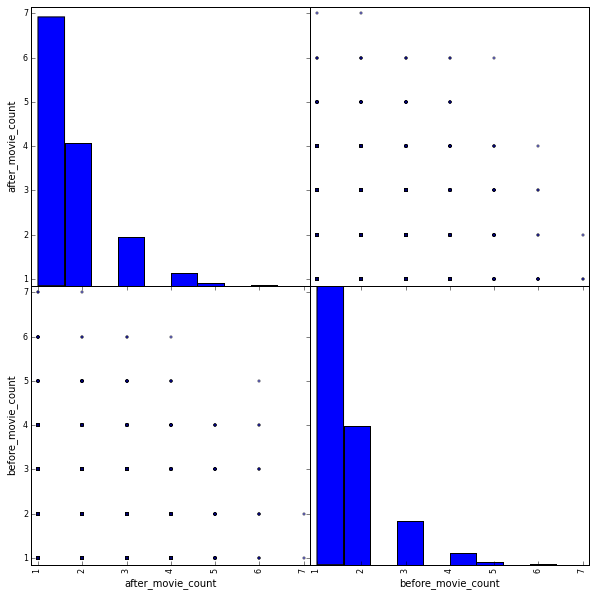

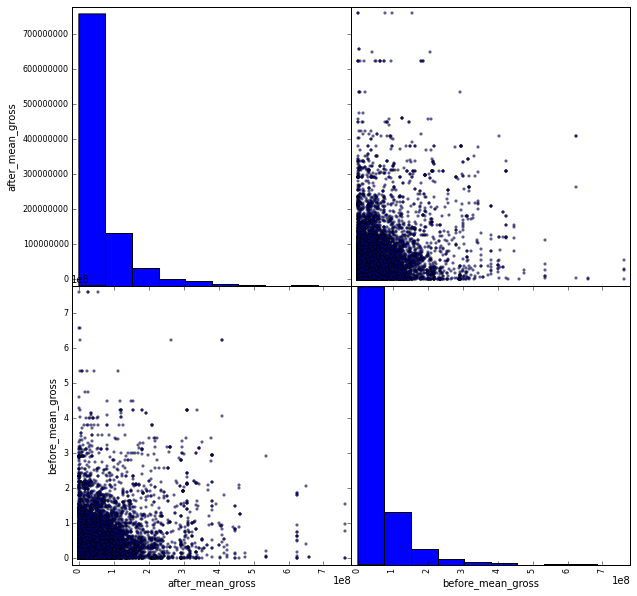

In [30]:
%matplotlib inline
cols = ['after_movie_count', 'before_movie_count']
pd.scatter_matrix(analysis_frame2[cols], figsize=(10, 10))
cols = ['after_mean_gross', 'before_mean_gross']
pd.scatter_matrix(analysis_frame2[cols], figsize=(10, 10))

In [31]:
count_list = range(1,6)

def analysis_loop(count_list):
    frame_list = []
    nc_dates = calc_comp_actor_df[calc_comp_actor_df['name'] == 'Nicolas Cage']
    nc_dates_list = nc_dates['date'].tolist()
    for x in count_list:
        date_range = x*300
        analysis_frame = date_loop(nc_dates_list, date_range)
        comparison_nc_df = calc_comp_actor_df[calc_comp_actor_df['name'] == 'Nicolas Cage']
        comparison_nc_df = comparison_nc_df[['movie', 'date']].reset_index()
        comparison_nc_df = comparison_nc_df[['movie', 'date']]
        compare_frame_test = comparison_nc_df['movie'].tolist()
        comparison_actor_df = calc_comp_actor_df
        comparison_actor_df['nc_movie'] = comparison_actor_df[['movie']].isin(compare_frame_test)
        comparison_actor_df[comparison_actor_df['nc_movie'] == True]
        ## This is a frame of actors, movies, and dates where they were in movies with Nicolas Cage
        nc_actor_frame = comparison_actor_df[comparison_actor_df['nc_movie'] == True]
        nc_actor_list = nc_actor_frame[['name','date']]
        actor_list = nc_actor_list['name'].tolist()
        date_list = nc_actor_list['date'].tolist()
        zip_list = zip(actor_list, date_list)
        analysis_frame['name_date'] = zip(analysis_frame['name'], analysis_frame['date'])
        analysis_frame['nc_movies'] = analysis_frame.name_date.apply(lambda x: x in zip_list)
        frame_list.append(analysis_frame)
    return frame_list

In [32]:
count_list = range(1,11)
all_models = analysis_loop(count_list)

/Users/johnwalters/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


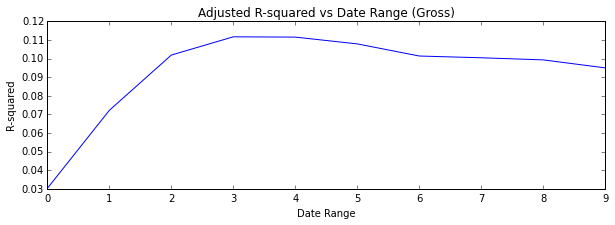

In [33]:
results = []
models = []
for frame in all_models:  #list of frames #originally labeled all_models
    y, X = dmatrices('after_mean_gross ~ before_mean_gross + nc_movies', data=frame, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    model = sm.OLS(y_train, X_train)
    models.append(model)
    results.append(model.fit())

len(results), len(models)
adj_r_sq = []

for i in range(len(results)):
    adj_r_sq.append(results[i].rsquared_adj)
plt.figure(figsize = (10, 3))
plt.plot(adj_r_sq)
#plt.plot(range(1, 16), adj_r_sq)

plt.title('Adjusted R-squared vs Date Range (Gross)')
plt.ylabel('R-squared')
plt.xlabel('Date Range')  
plt.gcf()
plt.savefig('r squared gross.png')

In [34]:
adj_r_sq

[0.03023351426996701,
 0.072179596215251607,
 0.1019106416726413,
 0.11170780615389742,
 0.11155259777872795,
 0.10790248577360662,
 0.10138610453317687,
 0.10044433289010524,
 0.099302929864506395,
 0.095007978667127957]

### Model 4 observes the affect Nicolas Cage has on individuals before and after 1200 days (approx 3 years) 

In [35]:
y, X = dmatrices('after_mean_gross ~ before_mean_gross + nc_movies', data=all_models[4], return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       after_mean_gross   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     1208.
Date:                Tue, 13 Oct 2015   Prob (F-statistic):               0.00
Time:                        09:03:04   Log-Likelihood:            -3.6148e+05
No. Observations:               18924   AIC:                         7.230e+05
Df Residuals:                   18921   BIC:                         7.230e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept           3.55e+07   5.09e+05     69.769      0.000      3.45e+07  3.65e+07
nc_movies[T.True] -6.365e+06   4.22e+06     -1.507      0.132     -1.46e+07  1.92e+06
before_mean_gross     0.3769      0.008     49.112      0.000         0.362     0.392
==============================================================================
Omnibus:                     8626.386   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64241.119
Skew:                           2.047   Prob(JB):                         0.00
Kurtosis:                      11.044   Cond. No.                     8.04e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.04e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111598f10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11227d410>]], dtype=object)

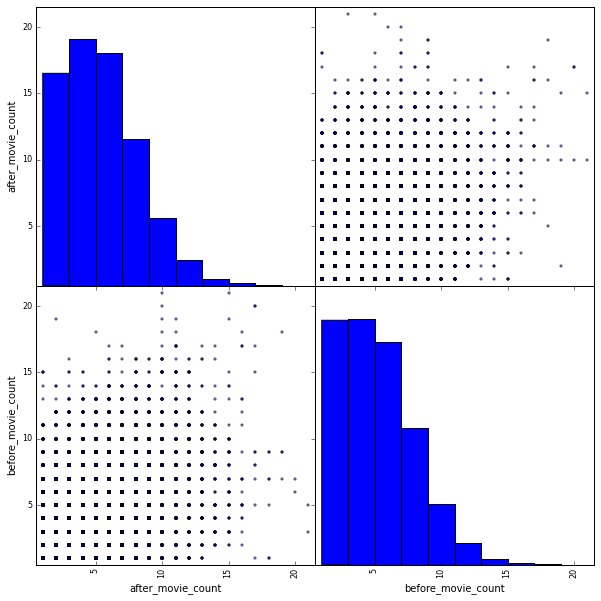

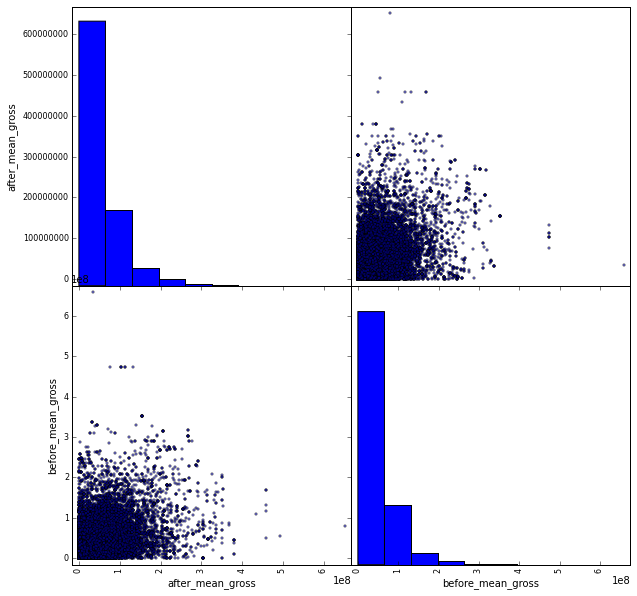

In [36]:
cols = ['after_movie_count', 'before_movie_count']
pd.scatter_matrix(all_models[4][cols], figsize=(10, 10))
cols = ['after_mean_gross', 'before_mean_gross']
pd.scatter_matrix(all_models[4][cols], figsize=(10, 10))

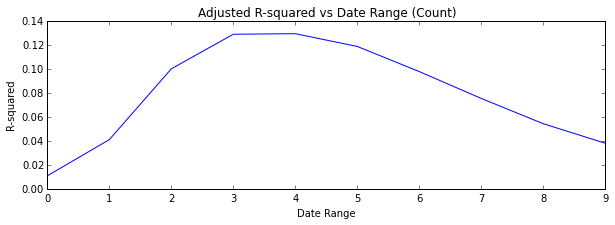

In [37]:
results = []
models = []
for frame in all_models:  #list of frames #originally labeled all_models
    y, X = dmatrices('after_movie_count ~ before_movie_count + nc_movies', data=frame, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    model = sm.OLS(y_train, X_train)
    models.append(model)
    results.append(model.fit())

len(results), len(models)
adj_r_sq = []

for i in range(len(results)):
    adj_r_sq.append(results[i].rsquared_adj)
plt.figure(figsize = (10, 3))
plt.plot(adj_r_sq)
plt.title('Adjusted R-squared vs Date Range (Count)')
plt.ylabel('R-squared')
plt.xlabel('Date Range')  
plt.gcf()
plt.savefig('r squared count.png')

In [38]:
y, X = dmatrices('after_movie_count ~ before_movie_count + nc_movies', data=all_models[4], return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      after_movie_count   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     1434.
Date:                Tue, 13 Oct 2015   Prob (F-statistic):               0.00
Time:                        09:03:10   Log-Likelihood:                -45194.
No. Observations:               18924   AIC:                         9.039e+04
Df Residuals:                   18921   BIC:                         9.042e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              3.2064      0.037     85.917      0.000         3.133     3.280
nc_movies[T.True]      0.8743      0.233      3.750      0.000         0.417     1.331
before_movie_count     0.3633      0.007     53.181      0.000         0.350     0.377
==============================================================================
Omnibus:                     1652.465   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2263.022
Skew:                           0.726   Prob(JB):                         0.00
Kurtosis:                       3.873   Cond. No.                         67.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

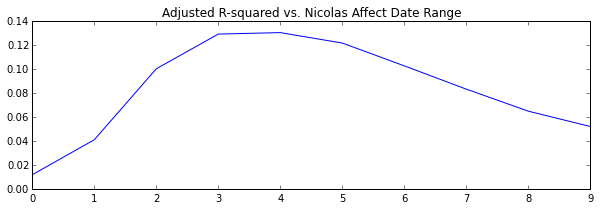

In [39]:
results = []
models = []
for frame in all_models:  #list of frames #originally labeled all_models
    y, X = dmatrices('after_movie_count ~ before_movie_count + before_mean_gross + nc_movies', data=frame, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    model = sm.OLS(y_train, X_train)
    models.append(model)
    results.append(model.fit())

len(results), len(models)
adj_r_sq = []

for i in range(len(results)):
    adj_r_sq.append(results[i].rsquared_adj)
plt.figure(figsize = (10, 3))
plt.plot(adj_r_sq)
#plt.plot(range(1, 16), adj_r_sq)
plt.title('Adjusted R-squared vs. Nicolas Affect Date Range')

In [40]:
y, X = dmatrices('after_movie_count ~ before_movie_count + before_mean_gross + nc_movies', data=all_models[4], return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      after_movie_count   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     964.8
Date:                Tue, 13 Oct 2015   Prob (F-statistic):               0.00
Time:                        09:03:17   Log-Likelihood:                -45182.
No. Observations:               18924   AIC:                         9.037e+04
Df Residuals:                   18920   BIC:                         9.040e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              3.2969      0.042     79.092      0.000         3.215     3.379
nc_movies[T.True]      0.8573      0.233      3.679      0.000         0.401     1.314
before_movie_count     0.3651      0.007     53.403      0.000         0.352     0.379
before_mean_gross  -2.061e-09   4.24e-10     -4.865      0.000     -2.89e-09 -1.23e-09
==============================================================================
Omnibus:                     1641.317   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2245.290
Skew:                           0.723   Prob(JB):                         0.00
Kurtosis:                       3.871   Cond. No.                     8.05e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.05e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

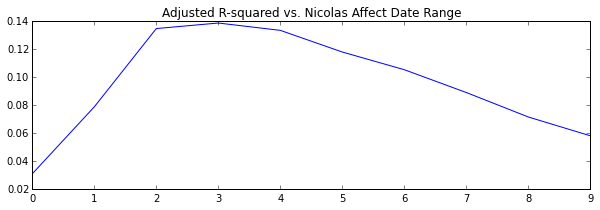

In [41]:
results = []
models = []
for frame in all_models:  #list of frames #originally labeled all_models
    y, X = dmatrices('after_total_gross ~ before_total_gross + nc_movies', data=frame, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    model = sm.OLS(y_train, X_train)
    models.append(model)
    results.append(model.fit())

len(results), len(models)
adj_r_sq = []

for i in range(len(results)):
    adj_r_sq.append(results[i].rsquared_adj)
plt.figure(figsize = (10, 3))
plt.plot(adj_r_sq)
#plt.plot(range(1, 16), adj_r_sq)
plt.title('Adjusted R-squared vs. Nicolas Affect Date Range')

In [42]:
y, X = dmatrices('after_total_gross ~ before_total_gross + nc_movies', data=all_models[3], return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      after_total_gross   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     1538.
Date:                Tue, 13 Oct 2015   Prob (F-statistic):               0.00
Time:                        09:03:22   Log-Likelihood:            -3.7617e+05
No. Observations:               18238   AIC:                         7.524e+05
Df Residuals:                   18235   BIC:                         7.524e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept           1.375e+08   2.23e+06     61.636      0.000      1.33e+08  1.42e+08
nc_movies[T.True]  -6.509e+06   1.93e+07     -0.337      0.736     -4.44e+07  3.14e+07
before_total_gross     0.4272      0.008     55.455      0.000         0.412     0.442
==============================================================================
Omnibus:                     7343.728   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37164.102
Skew:                           1.905   Prob(JB):                         0.00
Kurtosis:                       8.864   Cond. No.                     3.44e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f6d3ed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a147d10>]], dtype=object)

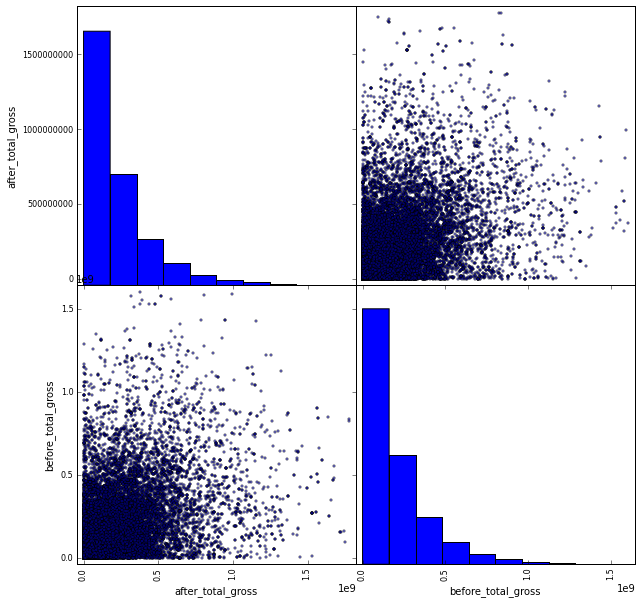

In [43]:
cols = ['after_total_gross', 'before_total_gross']
pd.scatter_matrix(all_models[3][cols], figsize=(10, 10))

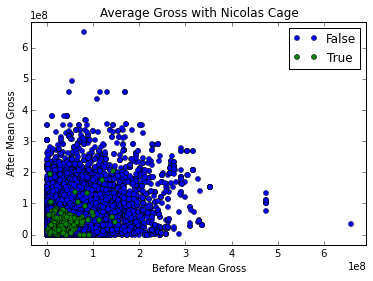

In [44]:
groups = all_models[4].groupby('nc_movies')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.before_mean_gross, group.after_mean_gross, marker='o', linestyle='', ms=5, label=name)
ax.legend()
plt.ylabel('After Mean Gross')
plt.xlabel('Before Mean Gross')
plt.title('Average Gross with Nicolas Cage')
plt.gcf()
plt.savefig('avg gross.png')
plt.show()


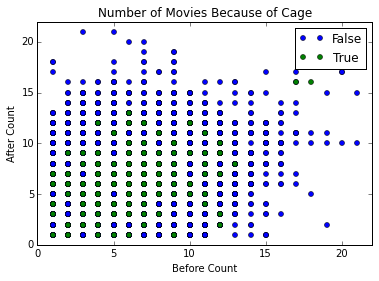

In [45]:
groups = all_models[4].groupby('nc_movies')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.before_movie_count, group.after_movie_count, marker='o', linestyle='', ms=5, label=name)
ax.legend()
plt.ylabel('After Count')
plt.xlabel('Before Count')
plt.title('Number of Movies Because of Cage')
plt.gcf()
plt.savefig('count.png')
plt.show()

In [46]:
y, X = dmatrices('after_movie_count ~ before_movie_count + before_mean_gross + nc_movies', data=all_models[4], return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      after_movie_count   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     964.8
Date:                Tue, 13 Oct 2015   Prob (F-statistic):               0.00
Time:                        09:03:33   Log-Likelihood:                -45182.
No. Observations:               18924   AIC:                         9.037e+04
Df Residuals:                   18920   BIC:                         9.040e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              3.2969      0.042     79.092      0.000         3.215     3.379
nc_movies[T.True]      0.8573      0.233      3.679      0.000         0.401     1.314
before_movie_count     0.3651      0.007     53.403      0.000         0.352     0.379
before_mean_gross  -2.061e-09   4.24e-10     -4.865      0.000     -2.89e-09 -1.23e-09
==============================================================================
Omnibus:                     1641.317   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2245.290
Skew:                           0.723   Prob(JB):                         0.00
Kurtosis:                       3.871   Cond. No.                     8.05e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.05e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
predicts = results.predict(X_test)
predicts

array([ 4.38668622,  6.84560091,  4.32793998, ...,  3.97411855,
        4.53929255,  4.78457511])

In [48]:
mse = mean_squared_error(y_test, predicts)

In [49]:
mse

6.8350432271236112

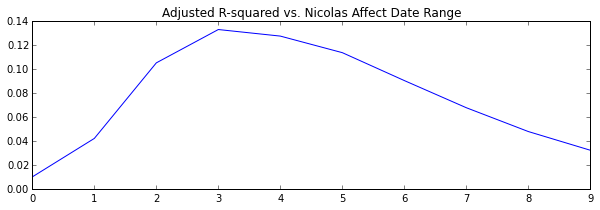

In [51]:
results = []
models = []
for frame in all_models:  #list of frames #originally labeled all_models
    y, X = dmatrices('np.sqrt(after_movie_count) ~ np.sqrt(before_movie_count) + nc_movies', data=frame, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    model = sm.OLS(y_train, X_train)
    models.append(model)
    results.append(model.fit())

len(results), len(models)
adj_r_sq = []

for i in range(len(results)):
    adj_r_sq.append(results[i].rsquared_adj)
plt.figure(figsize = (10, 3))
plt.plot(adj_r_sq)
#plt.plot(range(1, 16), adj_r_sq)
plt.title('Adjusted R-squared vs. Nicolas Affect Date Range')

In [ ]:
groups = all_models[4].groupby('nc_movies')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.before_movie_count, group.after_movie_count, marker='o', linestyle='', ms=5, label=name)
ax.legend()
plt.ylabel('After Count')
plt.xlabel('Before Count')
plt.title('Number of Movies Because of Cage')
plt.gcf()
plt.savefig('count.png')
plt.show()